In [1]:
#%pip install git+https://github.com/kmayerb/tcrdist3.git@0.2.2
from tcrdist.repertoire import TCRrep
import pwseqdist as pw
from tcrdist.rep_funcs import _pws, _pw
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Loading in data and selecting relevant columns

In [2]:
df = pd.read_csv('vdjdb_full.txt', delimiter = '\t')
# Based on the guidance, let's start preprocessing by filtering the dataset based on quality scores.

relevant_columns = [
    'cdr3.alpha', 'v.alpha', 'j.alpha', 'cdr3.beta', 'v.beta', 'd.beta', 'j.beta',
    'species', 'mhc.a', 'mhc.b', 'antigen.gene','antigen.epitope', 'vdjdb.score'
]

# For the purpose of this example, we won't filter out lower-quality scores to avoid data imbalance,
# but in practice, you may want to consider this based on the dataset's size and distribution.
filtered_data = df[relevant_columns]
# Displaying the first few rows of the filtered dataset to verify the selection
filtered_data


C:\Users\vikra\AppData\Local\Temp\ipykernel_18996\2383415646.py:1: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('vdjdb_full.txt', delimiter = '\t')


,cdr3.alpha,v.alpha,j.alpha,cdr3.beta,v.beta,d.beta,j.beta,species,mhc.a,mhc.b,antigen.gene,antigen.epitope,vdjdb.score
0,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,CASSYLPGQGDHYSNQPQHF,TRBV13*01,NaN,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,Nef,FLKEKGGL,2
1,NaN,NaN,NaN,CASSFEAGQGFFSNQPQHF,TRBV13*01,NaN,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,Nef,FLKEKGGL,2
2,CAVPSGAGSYQLTF,TRAV20*01,TRAJ28*01,CASSFEPGQGFYSNQPQHF,TRBV13*01,NaN,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,Nef,FLKEKGGL,2
3,CAVKASGSRLT,TRAV2*01,NaN,CASSYEPGQVSHYSNQPQHF,TRBV13*01,NaN,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,Nef,FLKEKGGL,2
4,CAYRPPGTYKYIF,TRAV38-2/DV8*01,TRAJ40*01,CASSALASLNEQFF,TRBV14*01,NaN,TRBJ2-1*01,HomoSapiens,HLA-B*08,B2M,Nef,FLKEKGGL,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
62172,CMDEGGSNYKLTF,TRAV26-1*01,TRAJ53*01,CASSVRSTDTQYF,TRBV7-2*01,NaN,TRBJ2-3*01,HomoSapiens,HLA-DQA1*05:01,HLA-DQB1*02:01,Gluten,PQPELPYPQPQL,0
62173,CSLYNNNDMRF,TRAV26-1*01,TRAJ43*01,CASSLRYTDTQYF,TRBV7-2*01,NaN,TRBJ2-3*01,HomoSapiens,HLA-DQA1*05:01,HLA-DQB1*02:01,Gluten,PQPELPYPQPQL,0
62174,CALSTDSWGKLQF,TRAV6*01,TRAJ24*01,CASSPGQGGDNEQFF,TRBV7-3*01,NaN,TRBJ2-1*01,HomoSapiens,HLA-DQA1*05:01,HLA-DQB1*02:01,Gluten,PQQPFPQPEQPFP,0
62175,CAPQGATNKLIF,TRAV12-2*01,TRAJ32*01,CASSLGAGGQETQYF,TRBV5-1*01,NaN,TRBJ2-5*01,HomoSapiens,HLA-DQA1*05:01,HLA-DQB1*02:01,Gluten,PQQPFPQPEQPFP,2


# examining missing and unique values

In [3]:
# Checking for missing values in crucial columns
missing_values = filtered_data.isnull().sum()

# Examining the number of unique values in categorical columns for potential encoding strategies
unique_values = filtered_data.nunique()

# Preparing the report
report = {
    "Missing Values": missing_values,
    "Unique Values": unique_values
}

report


{'Missing Values': cdr3.alpha         24128
 v.alpha            24204
 j.alpha            25157
 cdr3.beta           7455
 v.beta              7446
 d.beta             41741
 j.beta              7541
 species                0
 mhc.a                  0
 mhc.b                  0
 antigen.gene          31
 antigen.epitope        0
 vdjdb.score            0
 dtype: int64,
 'Unique Values': cdr3.alpha         27097
 v.alpha              158
 j.alpha               65
 cdr3.beta          41899
 v.beta                91
 d.beta                12
 j.beta                25
 species                3
 mhc.a                119
 mhc.b                 45
 antigen.gene         268
 antigen.epitope     1169
 vdjdb.score            4
 dtype: int64}

In [4]:
# Removing rows with missing cdr3 sequences
df_cleaned = filtered_data.dropna(subset=['cdr3.alpha', 'cdr3.beta'])
df_cleaned.reset_index(drop=True, inplace=True)
df_cleaned
missing_values_d = df_cleaned['d.beta'].isnull().sum()
missing_values_d

13811

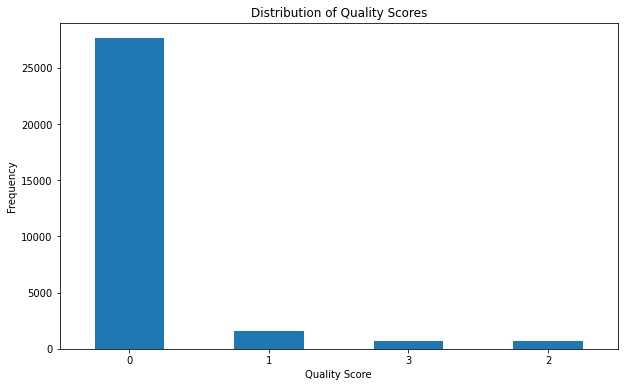

0    27629
1     1580
3      717
2      668
Name: vdjdb.score, dtype: int64

In [5]:
import matplotlib.pyplot as plt

# Assuming 'df_cleaned' is your cleaned DataFrame after removing rows with missing cdr3 sequences
quality_scores = df_cleaned['vdjdb.score'].value_counts()

# Plotting the distribution of quality scores
plt.figure(figsize=(10, 6))
quality_scores.plot(kind='bar')
plt.title('Distribution of Quality Scores')
plt.xlabel('Quality Score')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Keeping the x-axis labels horizontal for readability
plt.show()
quality_scores

whilst 0 is the most frequent class, the data with a score of 0 can be seen to be unreliable, so it is filtered out.

In [6]:
# Filtering out data points with a quality score of 0
df_filtered = df_cleaned[df_cleaned['vdjdb.score'] > 0]
# Removing the 'd.beta' column from the filtered DataFrame
df_filtered = df_filtered.drop(columns=['d.beta'])

df_filtered[:]



,cdr3.alpha,v.alpha,j.alpha,cdr3.beta,v.beta,j.beta,species,mhc.a,mhc.b,antigen.gene,antigen.epitope,vdjdb.score
0,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,Nef,FLKEKGGL,2
1,CAVPSGAGSYQLTF,TRAV20*01,TRAJ28*01,CASSFEPGQGFYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,Nef,FLKEKGGL,2
2,CAVKASGSRLT,TRAV2*01,NaN,CASSYEPGQVSHYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,Nef,FLKEKGGL,2
3,CAYRPPGTYKYIF,TRAV38-2/DV8*01,TRAJ40*01,CASSALASLNEQFF,TRBV14*01,TRBJ2-1*01,HomoSapiens,HLA-B*08,B2M,Nef,FLKEKGGL,2
4,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,Nef,FLKEQGGL,2
...,...,...,...,...,...,...,...,...,...,...,...,...
30549,CIALNARLMF,TRAV26-1*01,TRAJ31*01,CASSLRATDTQYF,TRBV7-2*01,TRBJ2-3*01,HomoSapiens,HLA-DQA1*05:01,HLA-DQB1*02:01,Gluten,PQPELPYPQPQL,2
30550,CAMREGRYSSASKIIF,TRAV14/DV4*01,TRAJ3*01,CATSRAGGGGEKLFF,TRBV15*01,TRBJ1-4*01,HomoSapiens,HLA-DQA1*05:01,HLA-DQB1*02:01,Gluten,FPQPEQPFPWQP,2
30551,CLVGDGDGGATNKLIF,TRAV4*01,TRAJ32*01,CASSQGSGGNEQFF,TRBV4-3*01,TRBJ2-1*01,HomoSapiens,HLA-DQA1*05:01,HLA-DQB1*02:01,Gluten,FPQPEQPFPWQP,2
30553,CAASVLYGSSNTGKLIF,TRAV29/DV5*01,TRAJ37*01,CASSIVGSGGYNEQFF,TRBV19*01,TRBJ2-1*01,HomoSapiens,HLA-DQA1*05:01,HLA-DQB1*02:01,Gluten,QLQPFPQPELPY,2


In [7]:
df_slim = df_filtered.iloc[:,[0,1,2,3,4,5,6,9,10]]

df_slim.rename(columns={'cdr3.alpha': 'cdr3_a_aa', 'cdr3.beta': 'cdr3_b_aa', 'v.alpha':'v_a_gene','j.alpha': 'j_a_gene','v.beta': 'v_b_gene','j.beta': 'j_b_gene',}, inplace=True)

df_slim.to_csv('df_slim.csv', index = False)
df_slim

C:\Users\vikra\AppData\Local\Temp\ipykernel_18996\1706405028.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_slim.rename(columns={'cdr3.alpha': 'cdr3_a_aa', 'cdr3.beta': 'cdr3_b_aa', 'v.alpha':'v_a_gene','j.alpha': 'j_a_gene','v.beta': 'v_b_gene','j.beta': 'j_b_gene',}, inplace=True)


,cdr3_a_aa,v_a_gene,j_a_gene,cdr3_b_aa,v_b_gene,j_b_gene,species,antigen.gene,antigen.epitope
0,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,Nef,FLKEKGGL
1,CAVPSGAGSYQLTF,TRAV20*01,TRAJ28*01,CASSFEPGQGFYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,Nef,FLKEKGGL
2,CAVKASGSRLT,TRAV2*01,NaN,CASSYEPGQVSHYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,Nef,FLKEKGGL
3,CAYRPPGTYKYIF,TRAV38-2/DV8*01,TRAJ40*01,CASSALASLNEQFF,TRBV14*01,TRBJ2-1*01,HomoSapiens,Nef,FLKEKGGL
4,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,Nef,FLKEQGGL
...,...,...,...,...,...,...,...,...,...
30549,CIALNARLMF,TRAV26-1*01,TRAJ31*01,CASSLRATDTQYF,TRBV7-2*01,TRBJ2-3*01,HomoSapiens,Gluten,PQPELPYPQPQL
30550,CAMREGRYSSASKIIF,TRAV14/DV4*01,TRAJ3*01,CATSRAGGGGEKLFF,TRBV15*01,TRBJ1-4*01,HomoSapiens,Gluten,FPQPEQPFPWQP
30551,CLVGDGDGGATNKLIF,TRAV4*01,TRAJ32*01,CASSQGSGGNEQFF,TRBV4-3*01,TRBJ2-1*01,HomoSapiens,Gluten,FPQPEQPFPWQP
30553,CAASVLYGSSNTGKLIF,TRAV29/DV5*01,TRAJ37*01,CASSIVGSGGYNEQFF,TRBV19*01,TRBJ2-1*01,HomoSapiens,Gluten,QLQPFPQPELPY


In [8]:
print(df_slim['species'].unique())

['HomoSapiens' 'MusMusculus']


In [9]:
df_mouse = df_slim[df_slim['species'] == 'MusMusculus']
df_human = df_slim[df_slim['species']=='HomoSapiens']
print(df_mouse.shape)
print(df_human.shape)

(925, 9)
(2040, 9)


In [10]:
# Filtering rows where species is "Mus" (assuming "Mus" represents mouse)
# It seems from the initial peek that the dataset might not contain "Mus" directly, so let's filter for anything that's not "HomoSapiens"
# to potentially capture the mouse data if labeled differently (e.g., Mus musculus or simply Mus)



# Creating the datasets
# 1. Mouse species data with alpha chains
human_alpha = df_human[['cdr3_a_aa', 'v_a_gene', 'j_a_gene', 'species','antigen.gene',	'antigen.epitope']]

# 2. Mouse species data with beta chains
human_beta = df_human[['cdr3_b_aa', 'v_b_gene', 'j_b_gene', 'species', 'antigen.gene',	'antigen.epitope']]

# 3. Mouse species data with both chains
human_both = df_human.copy()
# Resetting index for each dataset before saving
human_alpha.reset_index(drop=True, inplace=True)
human_beta.reset_index(drop=True, inplace=True)
human_both.reset_index(drop=True, inplace=True)


# Let's check the number of rows in each dataset to ensure we have mouse data
#mouse_alpha.shape[0], mouse_beta.shape[0], mouse_both.shape[0]

# Assuming your DataFrame is named mouse_beta_df and the epitope information is in a column named 'antigen.epitope'

# Count the occurrences of each epitope
epitope_counts = human_beta['antigen.epitope'].value_counts()

# Filter for epitopes with more than 4 entries
#epitopes_with_more_than_four_entries = epitope_counts[epitope_counts > 4].index

# Filter the original DataFrame
#filtered_human_beta_df = mouse_beta[mouse_beta['antigen.epitope'].isin(epitopes_with_more_than_four_entries)]
human_beta['antigen.epitope'].value_counts()


NLVPMVATV         461
GILGFVFTL         250
TFEYVSQPFLMDLE     87
GLCTLVAML          72
RPRGEVRFL          68
                 ... 
HYPYRLWHY           1
ATDALMTGF           1
ELAGIGALTV          1
ELAAIGILTV          1
KLTESLHKV           1
Name: antigen.epitope, Length: 341, dtype: int64

In [11]:
human_both.dropna(inplace=True)
human_both.shape

(1840, 9)

In [12]:
human_both.drop_duplicates(inplace=True)

In [13]:
human_both.shape

(1491, 9)

In [12]:
# <chains> - tcrdist3 accepts ['alpha', 'beta'] or ['alpha'] or ['beta']
chains = ['alpha', 'beta']
# <cdr3> We can choose either 'cdr3' or 'all'. Choosing 'all' will
# compute distances using CDR1,CDR2, and CDR2.5 as well as CDR3
cdrs = 'all'
organism = 'human'
db_file = 'alphabeta_gammadelta_db.tsv'

#beta only

In [13]:
tr = TCRrep(cell_df=human_both,
            organism='human',
            chains=['alpha', 'beta'],
            db_file='alphabeta_gammadelta_db.tsv',
            deduplicate=True)

#tr.show_incomplete()

C:\Users\vikra\anaconda3\lib\site-packages\tcrdist\repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
C:\Users\vikra\anaconda3\lib\site-packages\tcrdist\repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")
C:\Users\vikra\anaconda3\lib\site-packages\tcrdist\repertoire.py:792: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.cell_df['count'] = 1


,cdr3_a_aa,v_a_gene,j_a_gene,cdr3_b_aa,v_b_gene,j_b_gene,species,antigen.gene,antigen.epitope,cdr1_a_aa,cdr2_a_aa,pmhc_a_aa,cdr1_b_aa,cdr2_b_aa,pmhc_b_aa,cdr3_a_aa,cdr3_b_aa


In [14]:
X_beta = pd.DataFrame(tr.pw_alpha + tr.pw_beta)
Y_beta = tr.clone_df['antigen.epitope'].copy() # target labels
X_beta.to_csv('X_beta.csv',index = False)
Y_beta.to_csv('Y_beta.csv',index = False)

#clustering

In [15]:
X_beta = pd.DataFrame(tr.pw_alpha + tr.pw_beta)
X_beta

,0,1,2,3,4,5,6,7,8,9,...,1481,1482,1483,1484,1485,1486,1487,1488,1489,1490
0,0,294,295,296,363,361,310,291,238,304,...,328,288,277,286,276,276,301,315,328,341
1,294,0,243,243,323,356,241,262,293,235,...,328,220,155,266,259,259,278,255,323,278
2,295,243,0,4,284,332,247,182,275,220,...,341,213,254,290,247,247,231,210,303,277
3,296,243,4,0,282,332,247,180,279,220,...,339,213,252,288,251,251,229,214,302,277
4,363,323,284,282,0,271,317,241,334,257,...,298,313,304,346,329,329,378,347,393,344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1486,276,259,247,251,329,299,249,187,197,265,...,291,262,204,249,0,0,283,258,314,281
1487,301,278,231,229,378,365,301,253,276,279,...,245,277,283,301,283,283,0,297,316,272
1488,315,255,210,214,347,358,273,247,286,235,...,326,289,252,282,258,258,297,0,330,275
1489,328,323,303,302,393,359,327,309,310,343,...,333,295,324,342,314,314,316,330,0,320


In [16]:
Y_beta = tr.clone_df['antigen.epitope'].copy()
Y_beta

0         EPLPQGQLTAY
1          GADGVGKSAL
2           GILGFVFTL
3           GILGFVFTL
4           NLVPMVATV
            ...      
1486       GTSGSPIVNR
1487    LLEFYLAMPFATP
1488        YLQPRTFLL
1489        QYIKWPWYI
1490        NLVPMVATV
Name: antigen.epitope, Length: 1491, dtype: object

In [17]:
df_m = X_beta.copy()
df_m['epitope'] = Y_beta

In [18]:
df_m.head()

,0,1,2,3,4,5,6,7,8,9,...,1482,1483,1484,1485,1486,1487,1488,1489,1490,epitope
0,0,294,295,296,363,361,310,291,238,304,...,288,277,286,276,276,301,315,328,341,EPLPQGQLTAY
1,294,0,243,243,323,356,241,262,293,235,...,220,155,266,259,259,278,255,323,278,GADGVGKSAL
2,295,243,0,4,284,332,247,182,275,220,...,213,254,290,247,247,231,210,303,277,GILGFVFTL
3,296,243,4,0,282,332,247,180,279,220,...,213,252,288,251,251,229,214,302,277,GILGFVFTL
4,363,323,284,282,0,271,317,241,334,257,...,313,304,346,329,329,378,347,393,344,NLVPMVATV


In [19]:
df_bgm = df_m.copy()

In [20]:
print(len(df_m['epitope'].unique()))

319


In [21]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

kmeans = KMeans(n_clusters = 319) #319 epitopes
silhouette_score(X_beta, kmeans.fit_predict(X_beta))

0.19390285912641647

In [22]:
def mode_within_group(group):
    modes = group.mode()
    if len(modes) > 0:
        return modes.iloc[0]
    else:
        return pd.NA

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_beta, Y_beta)

In [24]:
df_test = X_test.copy()
df_test['epitope'] = y_test

In [25]:
kmeans.fit(X_train)
clusters = kmeans.predict(X_test)

In [26]:
df_test['cluster'] = clusters
df_test.head()

,0,1,2,3,4,5,6,7,8,9,...,1483,1484,1485,1486,1487,1488,1489,1490,epitope,cluster
489,311,290,284,282,272,280,295,250,265,293,...,198,288,267,267,322,318,313,332,DATYQRTRALVR,301
466,310,332,313,313,331,267,360,295,283,339,...,279,354,300,300,333,355,357,361,NLVPMVATV,112
396,306,293,264,264,279,344,300,248,295,207,...,294,333,285,285,293,309,353,282,TFEYVSQPFLMDLE,275
333,292,244,156,160,329,338,274,227,256,187,...,240,291,227,227,263,182,358,296,GILGFVFTL,2
935,300,315,305,309,299,351,298,259,266,311,...,281,314,268,268,312,333,326,270,NLVPMVATV,179


In [27]:
df_test['predicted_epitope'] = df_test.groupby('cluster')['epitope'].transform(mode_within_group)
df_test['True/False'] = df_test['predicted_epitope'] == df_test['epitope']
kmeans_accuracy = (df_test['True/False']==True).sum()/len(df_test['True/False'])
print(kmeans_accuracy)

0.710455764075067


In [28]:
df_test.head(30)

,0,1,2,3,4,5,6,7,8,9,...,1485,1486,1487,1488,1489,1490,epitope,cluster,predicted_epitope,True/False
489,311,290,284,282,272,280,295,250,265,293,...,267,267,322,318,313,332,DATYQRTRALVR,301,AAFKRSCLK,False
466,310,332,313,313,331,267,360,295,283,339,...,300,300,333,355,357,361,NLVPMVATV,112,NLVPMVATV,True
396,306,293,264,264,279,344,300,248,295,207,...,285,285,293,309,353,282,TFEYVSQPFLMDLE,275,TFEYVSQPFLMDLE,True
333,292,244,156,160,329,338,274,227,256,187,...,227,227,263,182,358,296,GILGFVFTL,2,GILGFVFTL,True
935,300,315,305,309,299,351,298,259,266,311,...,268,268,312,333,326,270,NLVPMVATV,179,NLVPMVATV,True
71,277,271,219,218,351,344,260,235,276,281,...,249,249,286,287,291,320,NLVPMVATV,7,GLCTLVAML,False
389,291,266,252,252,315,341,297,296,295,207,...,282,282,269,300,362,285,TFEYVSQPFLMDLE,275,TFEYVSQPFLMDLE,True
147,303,279,266,270,338,252,280,220,224,257,...,214,214,288,285,332,258,NLVPMVATV,260,NLVPMVATV,True
1224,311,321,339,337,331,330,286,309,260,323,...,291,291,316,367,337,289,VAANIVLTV,185,HPVTKYIM,False
49,296,273,239,241,317,283,218,197,255,281,...,230,230,296,301,269,308,TAFTIPSI,118,TAFTIPSI,True


In [29]:
from sklearn.cluster import DBSCAN
min_s_list = np.arange(1,10,1)
def cross_val(min_s_list):
    for min_s in min_s_list:
        df_dbs = df_m.copy()
        # Step 2: Fit DBSCAN on the training data
        dbscan = DBSCAN(min_samples=min_s)
        df_dbs['cluster'] = dbscan.fit_predict(X_beta)
        print(f"Silhouette Score - Min_s = {min_s}: {silhouette_score(X_beta, dbscan.fit_predict(X_beta))}, num_clusters: {len(df_dbs['cluster'].unique())}")
    return None

In [30]:
cross_val(min_s_list)

Silhouette Score - Min_s = 1: 0.11066398390342053, num_clusters: 1377
Silhouette Score - Min_s = 2: -0.1991212679710866, num_clusters: 52
Silhouette Score - Min_s = 3: -0.17170394778365208, num_clusters: 21
Silhouette Score - Min_s = 4: -0.13084289011948963, num_clusters: 12
Silhouette Score - Min_s = 5: -0.1117920057020586, num_clusters: 9
Silhouette Score - Min_s = 6: -0.087702666440491, num_clusters: 7
Silhouette Score - Min_s = 7: -0.09316966327235185, num_clusters: 6
Silhouette Score - Min_s = 8: -0.04804043868975829, num_clusters: 5
Silhouette Score - Min_s = 9: -0.04804043868975829, num_clusters: 5


In [55]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
cluster_list = [2,5,10,25,50,100,150,200,250,319,400,500]
def cross_val_kmeans(cluster_l):
    for n in cluster_l:
        kmeans = KMeans(n_clusters = n)
        cluster_labels = kmeans.fit_predict(X_beta)
        print(f"Silhouette Score - n = {n}: {silhouette_score(X_beta, cluster_labels)}, DB Score : {davies_bouldin_score(X_beta, cluster_labels)}")
    return None

In [56]:
cross_val_kmeans(cluster_list)

Silhouette Score - n = 2: 0.15012528346107581, DB Score : 2.217222221390654
Silhouette Score - n = 5: 0.12729314620255588, DB Score : 2.091576164558508
Silhouette Score - n = 10: 0.11757611784084948, DB Score : 2.225813237182476
Silhouette Score - n = 25: 0.131381023698259, DB Score : 2.2374314681753953
Silhouette Score - n = 50: 0.13655322865285646, DB Score : 2.2101093892430326
Silhouette Score - n = 100: 0.14721925293339527, DB Score : 2.0843139568900013


KeyboardInterrupt: 

Text(0.5, 1.0, 'The elbow method showing the optimal k')

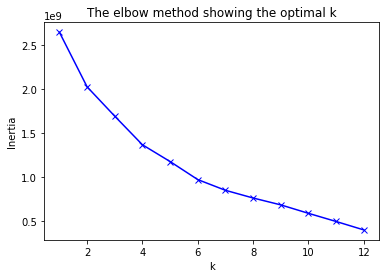

In [60]:
# Generate an elbow plot for this dataset
inertias = []
K = 30 
for k in cluster_list:
    kmm = KMeans(n_clusters=k).fit(X_beta) 
    kmm.fit(X_beta) 
    inertias.append(kmm.inertia_)
# Plot the elbow
plt.figure()
plt.plot(range(1, (len(cluster_list)+1)), inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The elbow method showing the optimal k')

In [35]:
from sklearn import metrics 

print(metrics.classification_report(df_test['predicted_epitope'].values,df_test['epitope'].values))

                          precision    recall  f1-score   support

               AAFKRSCLK       1.00      0.40      0.57         5
               AAGIGILTV       1.00      0.30      0.46        10
               AALPILFQV       1.00      1.00      1.00         1
         AAVVRFQEAANKQKQ       0.00      0.00      0.00         0
              ALDPHSGHFV       1.00      1.00      1.00         2
               ALLPGLPAA       1.00      1.00      1.00         1
               ALWEIQQVV       1.00      0.33      0.50         3
               ALYGFVPVL       1.00      0.40      0.57         5
           APRGPHGGAASGL       1.00      0.60      0.75         5
               CINGVCWTV       0.75      0.60      0.67         5
               CLGGLLTMV       1.00      1.00      1.00         1
            DATYQRTRALVR       0.80      0.67      0.73         6
          DFHFEVFNFVPCSI       1.00      0.33      0.50         3
           DPPALASTNAEVT       0.00      0.00      0.00         0
         

C:\Users\vikra\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vikra\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vikra\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
grouped = df_test.groupby('epitope')



# Initialize lists to store epitope, counts, and accuracy
epitopes = []
counts = []
accuracies = []

# Iterate over each group
for epitope, group in grouped:
    # Count the number of true predictions
    true_count = group['True/False'].sum()
    # Count the total number of predictions
    total_count = len(group)
    # Calculate accuracy
    accuracy = true_count / total_count
    # Store epitope, count, and accuracy in lists
    epitopes.append(epitope)
    counts.append(total_count)
    accuracies.append(accuracy)

# Create DataFrame to store epitopes, counts, and accuracies
summary_df = pd.DataFrame({
    'Epitope': epitopes,
    'Count': counts,
    'Accuracy': accuracies
})

# Print the summary DataFrame
print(summary_df.sort_values('Count', ascending=False).to_string())

                      Epitope  Count  Accuracy
67                  NLVPMVATV     67  0.805970
32                  GILGFVFTL     51  0.941176
102            TFEYVSQPFLMDLE     22  1.000000
119                 YLQPRTFLL     16  0.562500
46                 KLVALGINAV     14  0.714286
80                  QYIKWPWYI     13  0.615385
34                  GLCTLVAML      8  1.000000
90                  RPRGEVRFL      7  0.428571
95                  SPRWYFYYL      6  0.000000
50              LLEFYLAMPFATP      5  0.800000
18                EPLPQGQLTAY      5  1.000000
17                 ELAGIGILTV      5  0.400000
11               DATYQRTRALVR      5  0.800000
101                  TAFTIPSI      5  0.800000
14                 EAAGIGILTV      5  0.800000
84                  RLARLALVL      4  0.750000
9                   CINGVCWTV      4  0.750000
57              LPEPLPQGQLTAY      3  0.333333
85                 RLITGRLQSL      3  0.666667
1                   AAGIGILTV      3  1.000000
106          

In [37]:
df_test['epitope'].value_counts()

NLVPMVATV         67
GILGFVFTL         51
TFEYVSQPFLMDLE    22
YLQPRTFLL         16
KLVALGINAV        14
                  ..
LMDMHNGQL          1
LPEPLGQGQLTAY      1
AALPILFQV          1
VVVGADGVGK         1
RLPAKAPL           1
Name: epitope, Length: 122, dtype: int64

In [38]:
df_train = []

In [40]:
df_train['epitope'] = y_train

TypeError: list indices must be integers or slices, not str

In [41]:
y_test.shape

(373,)

In [42]:
y_train.shape

(1118,)

In [43]:
y_train

702           PQPELPYPQ
1185          NLVPMVATV
726           NLVPMVATV
660           RLPGVLPRA
1400           RMYSPVSI
             ...       
57            NYNYLYRLF
792     PSPSMGRDIKVQFQS
1171          QYIKWPWYI
386      TFEYVSQPFLMDLE
393      TFEYVSQPFLMDLE
Name: antigen.epitope, Length: 1118, dtype: object

In [44]:
y_train.unique()

array(['PQPELPYPQ', 'NLVPMVATV', 'RLPGVLPRA', 'RMYSPVSI', 'NYMPYFFTL',
       'QYIKWPWYI', 'PQPELPYPQPQL', 'KLVALGINAV', 'LLFGFPVYV',
       'KASEKIFYV', 'DATYQRTRALVR', 'VVMSWAPPV', 'EAAGIGILTV',
       'TLWCSPIKV', 'GLCTLVAML', 'GILGFVFTL', 'APRGPHGGAASGL',
       'EEYLQAFTY', 'KAFSPEVIPMF', 'YLGGPDFPTI', 'CINGVCWTV', 'GPRLGVRAT',
       'RPHERNGFTVL', 'RPRGEVRFL', 'SPRWYFYYL', 'TFEYVSQPFLMDLE',
       'FTSDYYQLY', 'YLQPRTFLL', 'IPLTEEAEL', 'TPRVTGGGAM', 'QPFPQPEQPFP',
       'VYFLQSINF', 'GPEPLPQGQLTAY', 'PGVLLKEFTVSGNIL', 'YPDKVFRSSV',
       'IVTDFSVIK', 'FGDHPGHSY', 'HYPYRLWHY', 'KALARALKEGRIR',
       'VAANIVLTV', 'WSYDSTLLAY', 'EPLPQGQLTAY', 'AAFKRSCLK',
       'YQFGPDFPIA', 'GQVELGGGNAVEVCKGS', 'NLNCCSVPV', 'TAFTIPSI',
       'MLFSHGLVK', 'TLEYMDWLV', 'STRQALRPRADGPVG', 'IPSINVHHY',
       'KLSALGINAV', 'ELAGIGILTV', 'ALWGFFPVL', 'PFPQPELPY',
       'DPPALASTNAEVT', 'LPEPLPQGQLTAY', 'CISSCNPNL', 'HMTEVVRHC',
       'YHSIEWA', 'FLIYLDVSV', 'RYPLTLGWCF', 'MSQIMYNYPAMLGHA',
     

In [45]:
y_test.unique()

array(['DATYQRTRALVR', 'NLVPMVATV', 'TFEYVSQPFLMDLE', 'GILGFVFTL',
       'VAANIVLTV', 'TAFTIPSI', 'EPLPQGQLTAY', 'YLQPRTFLL', 'ALDPHSGHFV',
       'EAAGIGILTV', 'DFHFEVFNFVPCSI', 'RPRGEVRFL', 'QYIKWPWYI',
       'YMGVVYEM', 'ELAGIGILTV', 'LLEFYLAMPFATP', 'GILGLVFTL',
       'KASEKIFYV', 'KLSALGINAV', 'FNNFTVSFWLRVPKVSASHLE', 'FMPDFDLHL',
       'KLVALGINAV', 'AAGIGILTV', 'NYNYLYRLF', 'SPRWYFYYL', 'HMTEVVRHC',
       'SVCAGILSYGV', 'VVVGAVGVGKSALTIQLIQN', 'VLEEVDWLI', 'GLCTLVAML',
       'AAVVRFQEAANKQKQ', 'TLREIRRYQK', 'GPRLGVRAT', 'RLITGRLQSL',
       'FLKEKGGL', 'KLVAMGINAV', 'WLIRETQPITK', 'RLARLALVL', 'IVTDFSVIK',
       'PQPELPYPQ', 'AAFKRSCLK', 'MHQKRTAMFQDPQER', 'LQPFPQPELPYGSGGS',
       'GDFGLATEKSRWSGS', 'FPQPEQPFPWQP', 'YLEPGPVTA', 'YVMAYVMAGVGS',
       'FLYALALLL', 'IPLTEEAEL', 'TLWCSPIKV', 'VMAPRTLIL',
       'PPQIAANRSQLISLV', 'PQQPFPQPEQPFP', 'VVVGADGVGK', 'AALPILFQV',
       'LPEPLGQGQLTAY', 'CINGVCWTV', 'LMDMHNGQL', 'QLVHFVRDFAQL',
       'PFPQPELPY', 'EVLPFFLFF', 'V

In [47]:
from sklearn.metrics import accuracy_score

# Initialize KMeans model
kmeans = KMeans(n_clusters=319, random_state=42)

# Fit KMeans to the training data
kmeans.fit(X_train)

# Predict cluster labels for training and testing data
train_cluster_labels = kmeans.predict(X_train)
test_cluster_labels = kmeans.predict(X_test)

# Map cluster labels to class labels
def map_clusters_to_labels(cluster_labels, true_labels):
    cluster_to_label = {}
    for cluster in set(cluster_labels):
        cluster_samples = true_labels[cluster_labels == cluster]
        most_common_label = max(set(cluster_samples), key=list(cluster_samples).count)
        cluster_to_label[cluster] = most_common_label
    predicted_labels = [cluster_to_label[cluster] for cluster in cluster_labels]
    return predicted_labels

# Map cluster labels to class labels for training and testing data
train_pred_labels = map_clusters_to_labels(train_cluster_labels, y_train)
test_pred_labels = map_clusters_to_labels(test_cluster_labels, y_test)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, train_pred_labels)
test_accuracy = accuracy_score(y_test, test_pred_labels)

In [48]:
print(train_accuracy)

0.5518783542039356


In [49]:
print(test_accuracy)

0.6970509383378016


In [52]:
print(df_test['cluster'].value_counts().to_string())

275    9
2      9
194    7
229    6
14     5
308    5
0      5
109    5
222    5
251    5
245    4
90     4
84     4
38     4
54     3
31     3
195    3
151    3
148    3
140    3
150    3
301    3
58     3
221    3
274    3
237    3
18     3
16     3
126    3
29     3
12     3
276    3
287    3
96     3
5      3
310    3
228    3
258    3
36     3
107    3
299    3
95     3
185    3
117    3
68     3
43     3
235    3
37     3
66     2
121    2
259    2
113    2
40     2
50     2
15     2
260    2
57     2
64     2
56     2
188    2
192    2
181    2
297    2
133    2
72     2
186    2
179    2
48     2
7      2
116    2
82     2
44     2
152    2
49     2
143    2
286    2
137    2
106    2
75     2
231    2
141    2
3      2
73     2
190    2
28     2
123    2
67     2
172    2
42     2
87     2
155    2
24     2
131    2
311    2
32     2
4      1
88     1
159    1
91     1
136    1
26     1
298    1
288    1
233    1
209    1
182    1
169    1
10     1
156    1
122    1
39     1
2